
This script was used to perform grid search for inter-session RMS.

________________________________________________________________________________
Model consists of 6 fully-connected layers and one drop-out layer.<br>
Adam optimizer with initial learning rate=0.01 and exponential decay is used. Learning rate=0.1, 0.001 and step decay are also tested, but as they seemed to perform worse, they are excluded from GS.<br>
__________________
Number of nodes in all the layers, activation function and drop rate are grid search parameters:<br>

p = {'activation':['relu', 'elu'],<br>
     'lr': [0.01],# "RMSprop"],<br>
     '1_hidden_layer':  [32, 64],<br>
     '2_hidden_layer':  [64, 80] ,<br>
     '3_hidden_layer':  [64, 80],<br>
     '4_hidden_layer':  [64, 80, 128, 256],<br>
     '5_hidden_layer':  [64, 80, 128, 256],<br>
     '6_hidden_layer':  [64, 80, 128, 256],<br>
     'drop_rate': [0, 0.1, 0.2] ,<br>
     'epochs': [100]}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip uninstall tensorflow

In [ ]:
!pip install tensorflow==2.1

In [ ]:
import tensorflow as tf
print(tf.__version__)

In [ ]:
!pip install git+https://github.com/autonomio/talos@1.0

In [ ]:
import talos as ta
print(ta.__version__)

In [ ]:
import keras
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.layers import Embedding
from keras.models import Model

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding
import tensorflow as tf
from sklearn.model_selection import train_test_split
import math

Using TensorFlow backend.


session = False means inter-session
random_selection if we choose randomly selected sets, but if we want to use regulary splitted ones, then this should be false.

In [ ]:
session=False
reduced=False
random_selection=True
if session: 
  if reduced:
    folder='/content/drive/Shared drives/Nikolina/RMS data/1D features/Intra-session/RMS_features_200ms_s'+str(session)
  else:
    folder='/content/drive/Shared drives/Nikolina/RMS data/1D features/Intra-session/RMS_features_1s_s'+str(session)
    
  paths=[folder+'_train.csv',folder+'_valid.csv',folder+'_test.csv']
  grid_search_res='drive/Shared drives/Nikolina/29.5. Results/gs_session'+str(session)
else:
  paths=['','','']
  if random_selection:
    if reduced:
      paths[0]='/content/drive/Shared drives/Nikolina/RMS data/1D features/Inter-session/RMS_train_rs_200ms.csv'
      paths[1]='/content/drive/Shared drives/Nikolina/RMS data/1D features/Inter-session/RMS_valid_rs_200ms.csv'
      paths[2]='/content/drive/Shared drives/Nikolina/RMS data/1D features/Inter-session/RMS_test_rs_200ms.csv'
      
    else:
      paths[0]='/content/drive/Shared drives/Nikolina/RMS data/1D features/Inter-session/RMS_train_rs_1s.csv'
      paths[1]='/content/drive/Shared drives/Nikolina/RMS data/1D features/Inter-session/RMS_valid_rs_1s.csv'
      paths[2]='/content/drive/Shared drives/Nikolina/RMS data/1D features/Inter-session/RMS_test_rs_1s.csv'
  else:
    if reduced:
      paths[0]='/content/drive/Shared drives/Nikolina/RMS data/1D features/Inter-session/RMS_train_200ms.csv'
      paths[1]='/content/drive/Shared drives/Nikolina/RMS data/1D features/Inter-session/RMS_valid_200ms.csv'
      paths[2]='/content/drive/Shared drives/Nikolina/RMS data/1D features/Inter-session/RMS_test_200ms.csv'
      
    else:
      paths[0]='/content/drive/Shared drives/Nikolina/RMS data/1D features/Inter-session/RMS_train_1s.csv'
      paths[1]='/content/drive/Shared drives/Nikolina/RMS data/1D features/Inter-session/RMS_valid_1s.csv'
      paths[2]='/content/drive/Shared drives/Nikolina/RMS data/1D features/Inter-session/RMS_test_1s.csv'
    #grid_search_res='drive/Shared drives/Nikolina/Results/RMS - inter-session/NO random selection'

print(paths)


['/content/drive/Shared drives/Nikolina/RMS data/1D features/Inter-session/RMS_train_rs_1s.csv', '/content/drive/Shared drives/Nikolina/RMS data/1D features/Inter-session/RMS_valid_rs_1s.csv', '/content/drive/Shared drives/Nikolina/RMS data/1D features/Inter-session/RMS_test_rs_1s.csv']


Read the data.

In [ ]:
e=65
ch=np.arange(0,56,1)
df = pd.read_csv(paths[0])
in_train=df.values[ch,:].T
out_train=df.values[56:e,:].T

#valid
df = pd.read_csv(paths[1])
in_valid=df.values[ch,:].T
out_valid=df.values[56:e,:].T

#test
df = pd.read_csv(paths[2])
in_test=df.values[ch,:].T
out_test=df.values[56:e,:].T

print('train data: ', np.shape(in_train),np.shape(out_train))
print('validation data: ', np.shape(in_valid),np.shape(out_valid))
print('test data: ', np.shape(in_test),np.shape(out_test))

train data:  (10512, 56) (10512, 9)
validation data:  (3504, 56) (3504, 9)
test data:  (3504, 56) (3504, 9)


Define the model, lr scheduler and function for plotting the best resuls.

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping

def evaluation(prediction, desired_out, title=None, save=False, path=None,limit=None):
  """For a given predicted labels and ground truth, plots both of them.
  If set is large, use limit  (vector of two indeices) - boundaries to plot subset of the set. 
  f save, define also path as a folder and filename."""
  predicted_class=[]
  gt=[]

  for sample in range(np.shape(prediction)[0]):
    predicted_class.append(np.argmax(prediction[sample,:]))
    gt.append(np.argmax(desired_out[sample,:]))

  plt.figure(figsize=(20,10))
  if limit:
    plt.scatter(np.arange(0,limit[1]-limit[0],1),np.array(predicted_class[limit[0]:limit[1]])+1,color= '#E2A76F',linewidths=9)#'#FFA500'
    plt.scatter(np.arange(0,limit[1]-limit[0],1),np.array(gt[limit[0]:limit[1]])+1,color='#26292c',marker='*',linewidths=5)
  else:
    plt.scatter(np.arange(0,np.shape(prediction)[0],1),np.array(predicted_class)+1,color='#355C7D',linewidths=9)
    plt.scatter(np.arange(0,np.shape(prediction)[0],1),np.array(gt)+1,color='#FFA500',marker='*',linewidths=4)

  plt.xlabel('sample',fontsize=20)
  plt.ylabel('class',fontsize=20)
  if title:
    plt.title(title)
  plt.legend(('predicted class','ground truth'),prop={'size': 27}, bbox_to_anchor=(0.7,0.648))

  if save:
    plt.savefig(path)
  plt.show()


def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

"""
def step_decay(epoch,lrate):
   initial_lrate = 0.01
   drop = 0.25
   epochs_drop = 10.0
   lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   return lrate
"""

def create_mlp(X_train, y_train, X_val, y_val,params):
  dim=56
  model = Sequential()

  # first FC
  model.add(Dense(params['1_hidden_layer'], input_dim=dim, activation=params['activation']))

  # second FC
  model.add(Dense(params['2_hidden_layer'], 
                    activation=params['activation']))
  
  # third FC
  model.add(Dense(params['3_hidden_layer'], 
                    activation=params['activation']))
  
  # fourth FC
  model.add(Dense(params['4_hidden_layer'], 
                    activation=params['activation']))
  
  # fifth FC
  model.add(Dense(params['5_hidden_layer'], 
                  activation=params['activation']))
  
  # sixth FC
  model.add(Dense(params['6_hidden_layer'], 
                  activation=params['activation']))
  
  # droput
  model.add(Dropout(params['drop_rate']))

  #output
  model.add(Dense(9, activation="softmax"))
  
  # optimizer - Adam
  optim = keras.optimizers.Adam(learning_rate=params['lr'], beta_1=0.9, beta_2=0.99, epsilon=1e-7)
  model.compile(optimizer=optim, 
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  
  # define callbacks
  lrate_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)
  early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=40, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
  callbacks_list = [early_stopper,lrate_schedule]

  # fit
  history = model.fit(X_train, 
                  y_train,
                  epochs=params['epochs'],
                  verbose=0,
                  validation_data=[X_val, y_val],
                  callbacks=callbacks_list,
                  batch_size=64)
  

  return history, model

Define GS parameters.

In [ ]:
p = {'activation':['relu', 'elu'],
     'lr': [0.01],# "RMSprop"],
     '1_hidden_layer':  [32, 64],
     '2_hidden_layer':  [64, 80] ,
     '3_hidden_layer':  [64, 80],
     '4_hidden_layer':  [64, 80, 128, 256],
     '5_hidden_layer':  [64, 80, 128, 256],
     '6_hidden_layer':  [64, 80, 128, 256],
     'drop_rate': [0, 0.1, 0.2] ,
     'epochs': [100]}

Perform GS.

In [ ]:
from talos import Scan

h = Scan(in_train, 
         out_train, 
         model=create_mlp, 
         params=p,
         x_val=in_valid,
         y_val=out_valid,
         experiment_name = grid_search_res)

100%|██████████| 216/216 [1:48:58<00:00, 30.27s/it]


In [ ]:
if random_selection:
  path='/content/drive/Shared drives/Nikolina/Results/RMS - inter-session/results_random_split.csv'
else:
  path='/content/drive/Shared drives/Nikolina/Results/RMS - inter-session/results_regular_split.csv'
results=pd.read_csv(path) 

In [ ]:
val_acc=results.val_accuracy
print(max(val_acc))
best=np.where(val_acc==max(val_acc))[0]
print(best)
print(val_acc[best])

0.6640982031822205
[2956]
2956    0.664098
Name: val_accuracy, dtype: float64


In [ ]:
#e=regular split
p = {'activation':'relu',
     'lr': 0.01,# "RMSprop"],
     '1_hidden_layer':  32,
     '2_hidden_layer':  80 ,
     '3_hidden_layer':  80,
     '4_hidden_layer':  64,
     '5_hidden_layer':  80,
     '6_hidden_layer':  128,
     'drop_rate': 0.2 ,
     'epochs': 100}

In [ ]:
#e=random split
p = {'activation':'elu',
     'lr': 0.01,# "RMSprop"],
     '1_hidden_layer':  64,
     '2_hidden_layer':  80 ,
     '3_hidden_layer':  80,
     '4_hidden_layer':  128,
     '5_hidden_layer':  128,
     '6_hidden_layer':  256,
     'drop_rate': 0.2 ,
     'epochs': 100}

In [ ]:
predictions=[]
test_acc=[]
valid_acc=[]
train_acc=[]

for i in range(100):
  print('\nTraining, iteration '+ str(i))
  h,model=create_mlp(in_train, out_train, in_valid, out_valid,p)
  prediction = model.predict(in_test)
  test_scores = model.evaluate(in_test, out_test, verbose = 0, batch_size=64)
  
  print('Train accuracy:' , h.history['accuracy'][-1])
  print('Test accuracy:',test_scores[-1])
  print('Validation accuracy:',h.history['val_accuracy'][-1])

  predictions.append(prediction)

  test_acc.append(test_scores[-1])
  train_acc.append( h.history['accuracy'][-1])
  valid_acc.append(h.history['val_accuracy'][-1])


Training, iteration 0
Train accuracy: 0.786054
Test accuracy: 0.634132444858551
Validation accuracy: 0.6352739930152893

Training, iteration 1
Train accuracy: 0.8346651
Test accuracy: 0.6389840245246887
Validation accuracy: 0.6595319509506226

Training, iteration 2
Train accuracy: 0.8296233
Test accuracy: 0.5993150472640991
Validation accuracy: 0.6438356041908264

Training, iteration 3
Train accuracy: 0.8501712
Test accuracy: 0.6272830963134766
Validation accuracy: 0.657248854637146

Training, iteration 4
Train accuracy: 0.7986111
Test accuracy: 0.6372717022895813
Validation accuracy: 0.6484017968177795

Training, iteration 5
Train accuracy: 0.80878997
Test accuracy: 0.6175799369812012
Validation accuracy: 0.6529680490493774

Training, iteration 6
Train accuracy: 0.83723366
Test accuracy: 0.6312785148620605
Validation accuracy: 0.6486872434616089

Training, iteration 7
Train accuracy: 0.8270548
Test accuracy: 0.6124429106712341
Validation accuracy: 0.6432648301124573

Training, iterat

In [ ]:
print('train accuracy: '+ str(np.mean(train_acc)) + '+-' + str(np.std(train_acc)))
print('validation accuracy: '+ str(np.mean(valid_acc)) + '+-' + str(np.std(valid_acc)))
print('test accuracy: '+ str(np.mean(test_acc)) + '+-' + str(np.std(test_acc)))

train accuracy: 0.82975554+-0.013520471
validation accuracy: 0.6516952043771744+-0.009439525419916224
test accuracy: 0.6196147239208222+-0.01583102479754839


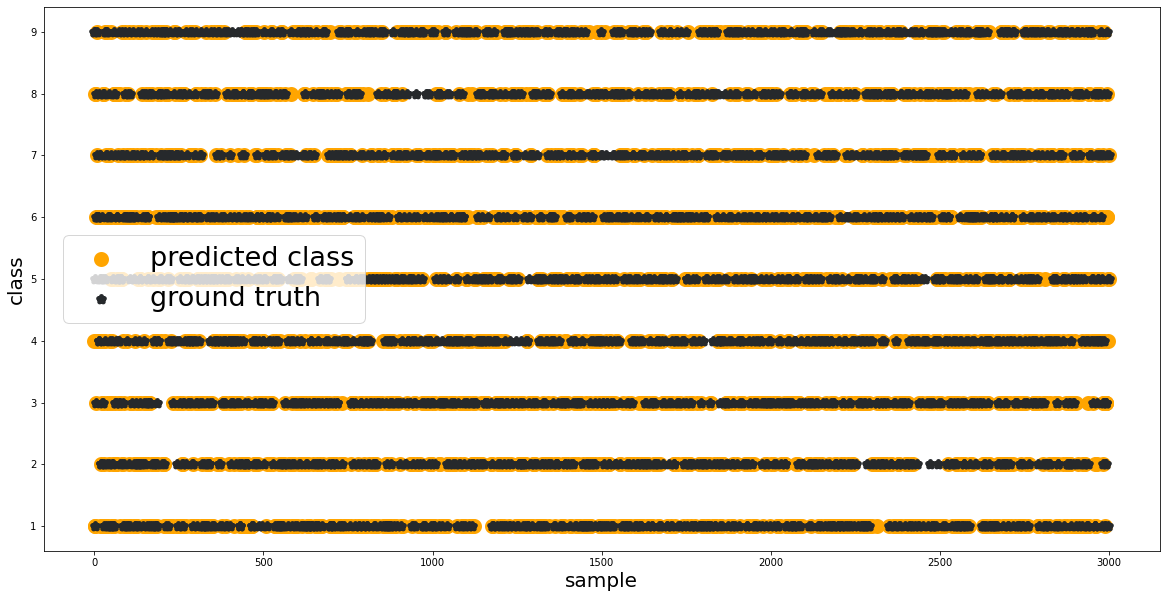

In [ ]:
pp=''
evaluation(prediction, out_test, title=None, save=False, path=pp,limit=[0,3000])

In [ ]:
ind=np.random.randint(0,3504,60)
a=prediction[ind]
b=out_test[ind]

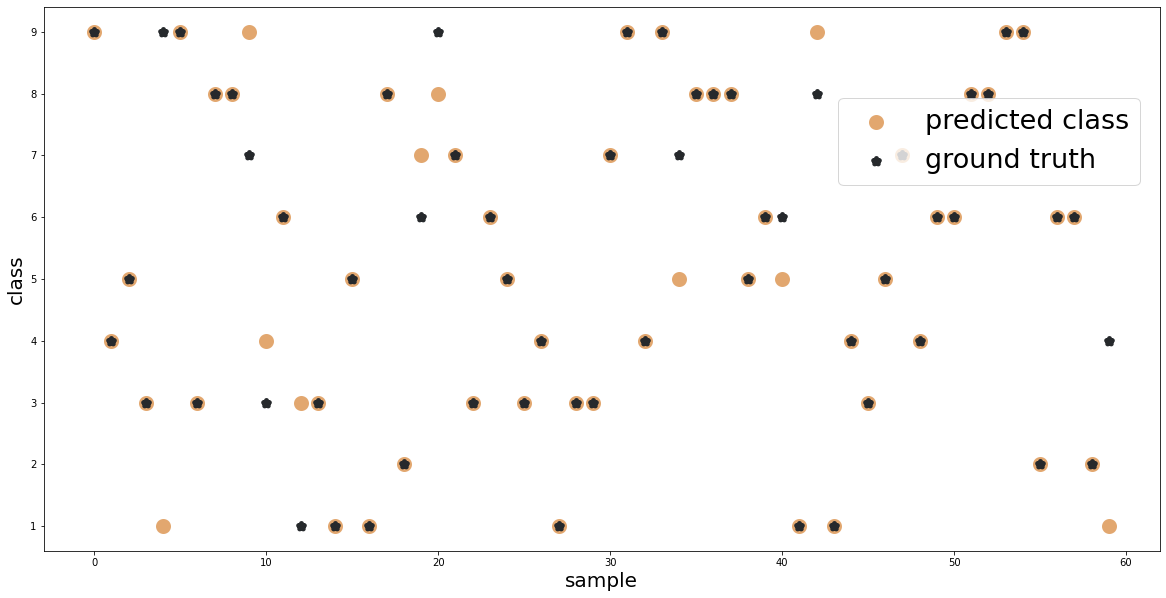

In [ ]:
pp='/content/drive/Shared drives/Nikolina/Results/Report figures/RMSinter_s_random.png'
evaluation(a, b, title=None, save=True, path=pp,limit=[0,60])